In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})
import seaborn as sns

In [3]:
# workdir 
BASE_DIR = Path(r'G:\spatial_data')
src_dir = Path(r'G:\spatial_data\reference\BGI_Stereo-seq_cell')

# analysis dir
RUN_ID = '20250508_gene_pattern_comparison'
analysis_dir = BASE_DIR / 'analysis' / RUN_ID

In [4]:
exp_mtx_ref = pd.read_csv(r'g:\spatial_data\processed\20230705_PRISM3D_mousebrain_HT_confocal\segmented\expression_matrix.csv', index_col=0)
gene_list_ref = [_.capitalize() for _ in exp_mtx_ref.columns]

In [5]:
mapped_genes_raw = pd.read_csv(src_dir / 'L20211217002.export.bin1.gem', sep='\t', comment='#', header=0, ) #index_col=0)
mapped_genes_raw.head()

,geneID,x,y,MIDCounts
0,0610005C13Rik,11864,11748,3
1,0610005C13Rik,6632,9074,1
2,0610005C13Rik,10339,15898,2
3,0610005C13Rik,4290,10831,2
4,0610005C13Rik,5714,9053,2


In [6]:
mapped_genes_raw['geneID'] = mapped_genes_raw['geneID'].replace({'3110035E14Rik':'Vxn'})
mapped_genes = mapped_genes_raw[mapped_genes_raw['geneID'].map(lambda x: x.capitalize()).isin(gene_list_ref)]
overlap_genes = mapped_genes['geneID'].unique()
print(len(overlap_genes))
print(overlap_genes)

30
['Vxn' 'Apod' 'Aqp4' 'Cck' 'Ctgf' 'Cx3cr1' 'Enpp2' 'Gad1' 'Gad2' 'Gapdh'
 'Gfap' 'Lamp5' 'Mbp' 'Nov' 'Nr4a2' 'Pcp4' 'Plcxd2' 'Plp1' 'Pmch' 'Prox1'
 'Pvalb' 'Rasgrf2' 'Rgs4' 'Rorb' 'Rprm' 'Slc17a7' 'Slc1a3' 'Snap25' 'Sst'
 'Vip']


In [109]:
# 定义旋转函数（与之前相同）
def rotate_points(points, theta_degrees, center=(0, 0)):
    theta = np.deg2rad(theta_degrees)
    translated = points - center
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    rotated = translated @ rotation_matrix.T
    rotated += center
    return rotated

# 提取坐标并转换为 NumPy 数组（注意顺序是 y, x）
coordinates = mapped_genes[['y', 'x']].values  # 形状为 (N, 2)

# 应用旋转（例如逆时针旋转90度）
rotated_coords = rotate_points(coordinates, theta_degrees=-25)

# 将结果写回 DataFrame（注意列名 Y, X 是大写）
mapped_genes['Y'] = rotated_coords[:, 0]  # 旋转后的 y 坐标
mapped_genes['X'] = rotated_coords[:, 1]  # 旋转后的 x 坐标
mapped_genes['Y'] = mapped_genes['Y'] - mapped_genes['Y'].min() + 10
mapped_genes['X'] = mapped_genes['X'] - mapped_genes['X'].min() + 10

In [117]:
from tifffile import imwrite

density_dir = Path(analysis_dir / 'BGI_gene_density')
density_dir.mkdir(exist_ok=True)

im_shape = int(mapped_genes['Y'].max())+10, int(mapped_genes['X'].max())+10
print(im_shape)

def plot_density_downsample(df, fac=30):
    y = (im_shape[0] // fac) + 1
    x = (im_shape[1] // fac) + 1
    coordinates = df[['Y','X']].astype(int).to_numpy()
    canvas = np.zeros((y*fac, x*fac),dtype=np.uint16)
    canvas[coordinates[:,0], coordinates[:,1]] += df['MIDCounts']
    canvas_down = canvas.reshape(y,fac,x,fac).sum(-1).sum(1)
    return canvas_down

for gene in tqdm(mapped_genes['geneID'].unique()):
    # if glob(str(density_dir / f'{gene}.tif')): continue
    # else: 
    image = plot_density_downsample(mapped_genes[mapped_genes['geneID']==gene])
    image = np.flip(image, axis=0)
    # image = np.flip(image, axis=1)
    imwrite(density_dir/f'{gene}.tif', image.astype(np.uint16))

(12822, 10190)


100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


In [114]:
from matplotlib.colors import LinearSegmentedColormap
# 直接定义白到红的渐变（无需修改原始Reds）
# white_reds = LinearSegmentedColormap.from_list('white_reds', ['white', 'red'])
# --- 1. 创建自定义颜色映射（Reds，0值为白色）---
# 获取原始Reds颜色映射
# reds_cmap = plt.get_cmap('Reds')
# # 提取颜色数组（将0位置的颜色改为白色）
# new_colors = reds_cmap(np.linspace(0, 1, 256))
# new_colors[0, :] = [1, 1, 1, 1]  # 白色（RGBA格式）
# # 生成新的颜色映射
# white_reds = LinearSegmentedColormap.from_list('white_reds', new_colors)
colors = [
    (1.0, 1.0, 1.0),  # 0.0: 白色 (RGB=255,255,255)
    (1.0, 0.8, 0.8),  # 0.2: 浅红
    (1.0, 0.0, 0.0),  # 0.5: 亮红 (RGB=255,0,0)
    (0.6, 0.0, 0.0)   # 1.0: 深红 (RGB=153,0,0)
]
imagej_reds = LinearSegmentedColormap.from_list('imagej_reds', colors)

(12822, 10190)


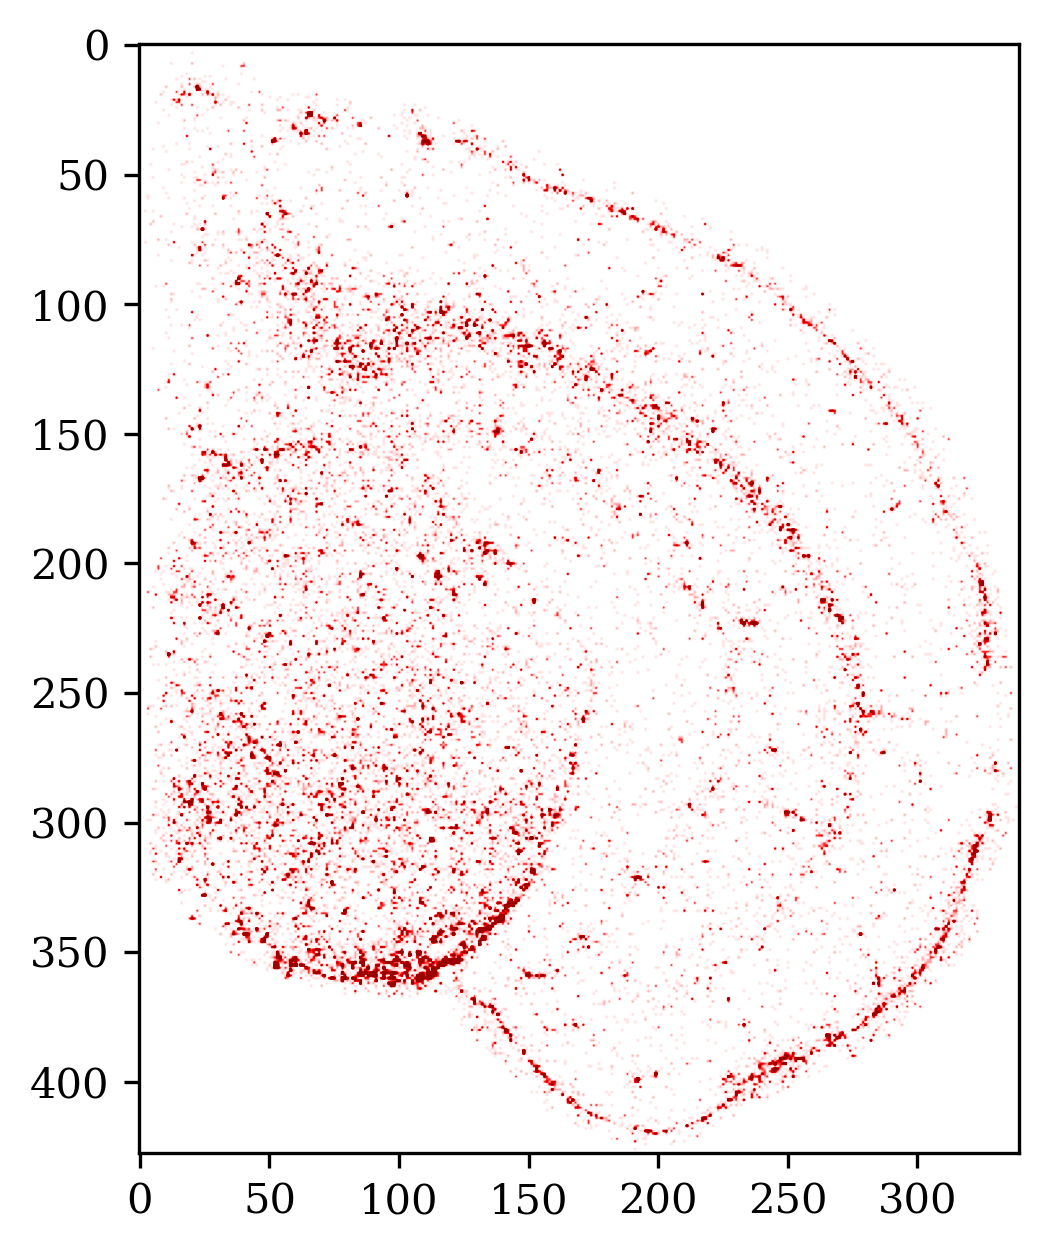

In [116]:
from tifffile import imwrite

density_dir = Path(analysis_dir / 'BGI_gene_density')
density_dir.mkdir(exist_ok=True)

im_shape = int(mapped_genes['Y'].max())+10, int(mapped_genes['X'].max())+10
print(im_shape)

def plot_density_downsample(df, fac=30):
    y = (im_shape[0] // fac) + 1
    x = (im_shape[1] // fac) + 1
    coordinates = df[['Y','X']].astype(int).to_numpy()
    canvas = np.zeros((y*fac, x*fac),dtype=np.uint16)
    canvas[coordinates[:,0], coordinates[:,1]] += df['MIDCounts']
    canvas_down = canvas.reshape(y,fac,x,fac).sum(-1).sum(1)
    return canvas_down

# gene = mapped_genes['geneID'].unique()[10]
gene = 'Apod'
image = plot_density_downsample(mapped_genes[mapped_genes['geneID']==gene])
image = np.flip(image, axis=0)
# image = np.flip(image, axis=1)

# from PIL import Image
# img = Image.fromarray(image)
plt.imshow(image,vmin=0,vmax=5,cmap=imagej_reds)
# img.save(str(outpath / f"{roi}_{gene_name}.png"), format='PNG')